# STROJNO UČENJE - PROJEKT
## EDA Student Performance Dataset
### Predviđanje uspjeha učenika pomoću demografskih i socio-ekonomskih informacija

# Sadržaj
[Library Import](#Library-import)

[Vizualizacija podataka](#Vizualizacija-podataka)

- [Kategoričke varijable](#Kategoričke-značajke)

- [Numeričke varijable](#Numeričke-značajke)

- [Usporedba spola](#Usporedba-spola)


[Feature Selection](#Feature-selection-&-encoding)

[Modeli](#Modeli)
- [Priprema podataka](#Priprema-podataka)

    -[Label Encoding](#Label-encoding)
    
    -[Train-test Split](#Train-Test-Split)

- [Regresija](#Modeli-linearne-regresije)

    -[Linearna Regresija](#Linearna-regresija)
    
    -[Lasso](#MultitaskLasso-Regresija-(3-izlaza))
    
    -[Ridge](#Ridge-regresija)
   
- [Slučajne šume](#slučajne-šume)

# Library import

In [1]:
#%% Imports


#SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn import feature_selection 

import squarify
from sklearn.pipeline import Pipeline


# Basic Imports 
import numpy as np
import pandas as pd

# Plotting 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

# Preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder

# Metrics 
import sklearn.metrics
from sklearn.metrics import *

# ML Models
import lightgbm as lgb
from lightgbm import LGBMRegressor 
import xgboost as xg 
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.linear_model import LinearRegression, Ridge
# Model Tuning 
from bayes_opt import BayesianOptimization

# Feature Importance 
import shap

# Ignore Warnings 
import warnings
warnings.filterwarnings('ignore')



# Import dataseta

In [2]:
df = pd.read_csv('StudentsPerformance.csv')

df['AVERAGE'] = df[['math score', 'reading score','writing score']].mean(axis=1)

# Vizualizacija podataka

In [3]:

df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,AVERAGE
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667
1,female,group C,some college,standard,completed,69,90,88,82.333333
2,female,group B,master's degree,standard,none,90,95,93,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333
4,male,group C,some college,standard,none,76,78,75,76.333333


Skup podataka sastoji se od 8 stupaca i 1000 redaka, odnosno podataka o studentima:

In [4]:
df.shape

(1000, 9)

## Kategoričke značajke

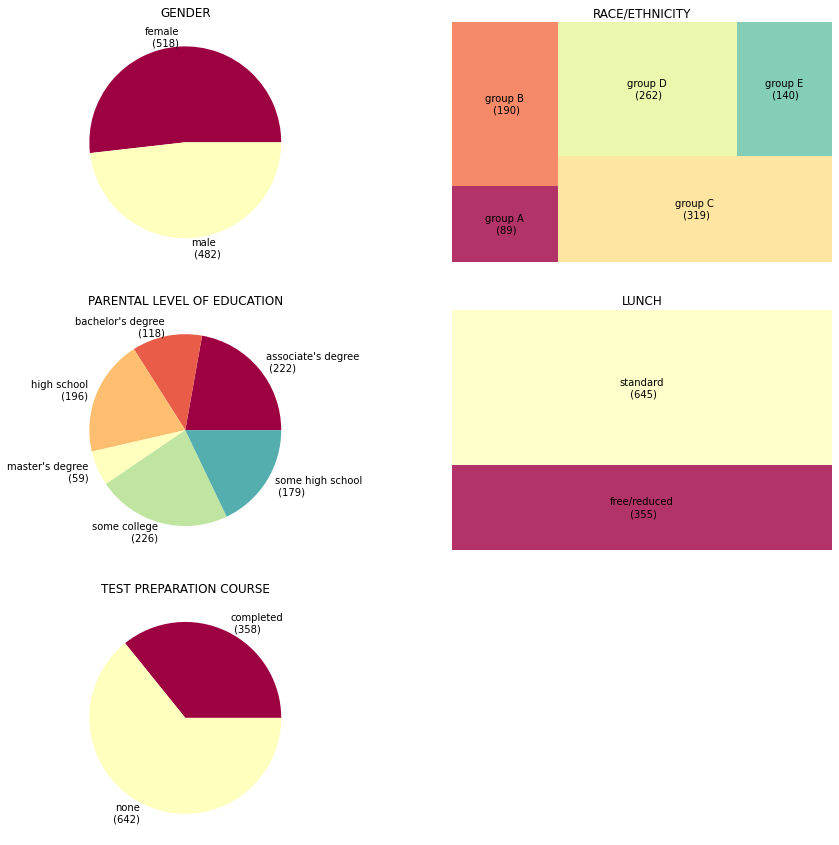

In [5]:
f, axes=plt.subplots(3, 2, figsize=(15, 15))
for i in range(5):
    plt.subplot(3, 2, i+1)
    
    df_grouped= df.groupby(df.columns[i]).size().reset_index(name='counts')
    labels = df_grouped.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
    sizes = df_grouped['counts'].values.tolist()
    colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]
    
    if i % 2 == 1:
       squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)
    else:
        plt.pie(sizes, labels=labels, colors=colors)
    plt.title(df.columns[i].upper())
    plt.axis('off')
    
plt.subplot(3, 2, 6)
plt.axis('off')
plt.show()

## Swarmplot kategoričkih atributa po oznaci,tj. broju bodova

<AxesSubplot:xlabel='parental level of education', ylabel='AVERAGE'>

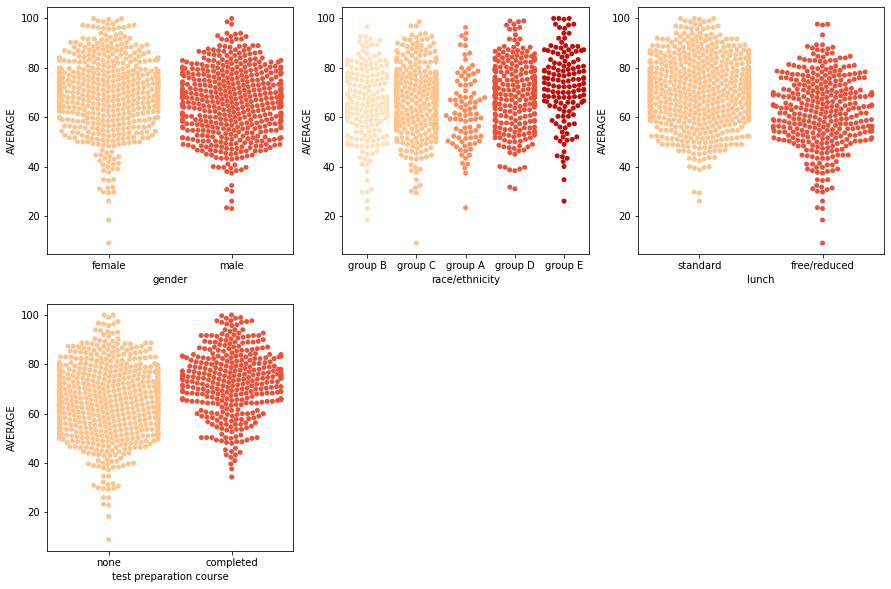

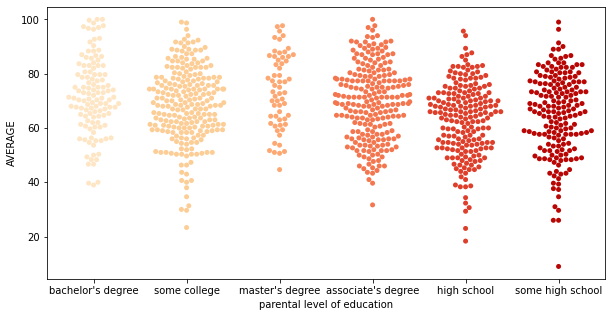

In [6]:
table=df.copy()
table = table.drop(["math score","reading score","writing score","AVERAGE","parental level of education"],axis = 'columns') 

plt.figure(figsize=(15,10))
for indx,val in enumerate(table.columns):
    plt.subplot(2,3,indx+1)
    sns.swarmplot(x=df[val],y=df['AVERAGE'],palette='OrRd')

plt.figure(figsize=(10,5))
sns.swarmplot(x=df['parental level of education'],y=df['AVERAGE'],palette='OrRd')
    

## Numeričke značajke

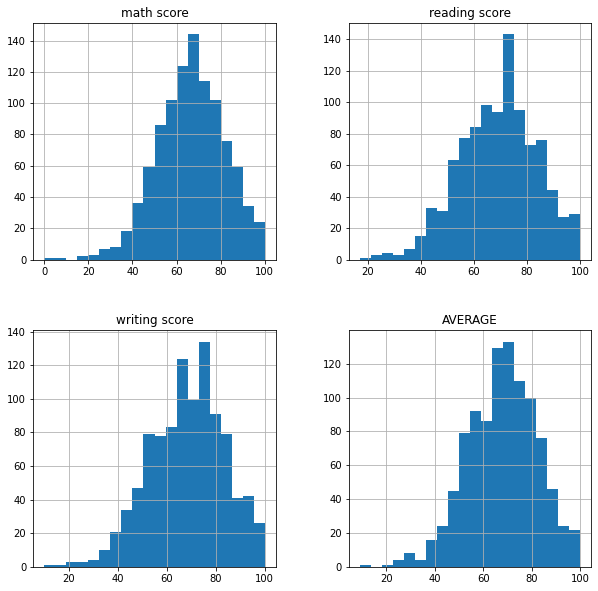

In [7]:
df.hist(figsize=(10,10),bins = 20)
plt.show()

# Feature selection & encoding

## Kodiranje atributa

Moramo napraviti preinake u našim podacima. Točnije, smetaju nam kategoričke varijable pošto algoritmi strojnog učenja ne rade sa kategoričkim varijablama. Postoji više pristupa tom problemu: 

    - One Hot Encoding (funkcija get_dummies)
    - Biblioteka LabelEncoder
    - Ručno, pomoću funkcije replace
    
Referenca: https://pbpython.com/categorical-encoding.html

In [8]:
# moramo napraviti label encoding
# pogledajmo prvo koje su nam vrijednosti u svakom stupcu
for col in df:
    if col == 'math score':
        break
    print(col, ' --> ', df[col].unique())

gender  -->  ['female' 'male']
race/ethnicity  -->  ['group B' 'group C' 'group A' 'group D' 'group E']
parental level of education  -->  ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
lunch  -->  ['standard' 'free/reduced']
test preparation course  -->  ['none' 'completed']


In [9]:
def find_and_replace(data):
    cleanup_nums = {
        'gender': { "female": 0, 'male': 1 },
        'race/ethnicity': { 'group A': 0, 'group B': 1, 'group C': 2, 'group D': 3, 'group E': 4 },
        'parental level of education': { 'some high school': 0, 'high school': 1,
                                        "associate's degree": 2, 'some college': 3,
                                        "bachelor's degree": 4, "master's degree": 5,  },
        'lunch': { 'standard': 0, 'free/reduced': 1 },
        'test preparation course': { 'none': 0, 'completed': 1 },
    }
    return df.replace(cleanup_nums)

#one hot encoding
def one_hot_encoding(data):
    # we rename first and last columns for scalability, so we dont have to change our code in multiple places
    return pd.get_dummies(data, columns=['gender', 'race/ethnicity', \
                                       'parental level of education', \
                                       'lunch', 'test preparation course'], \
                          drop_first=True) \
            .rename(columns={\
                             'gender_male' : 'gender',\
                             'test preparation course_none' : 'test preparation course'\
                            })




def encode_data(table_input,enc_type="ONEHOT",removeY=True):
    
    table= table_input.copy()
    
    #stupac koji je feature selection odabrao kao najmanje bitan
    
    if removeY:
        table = table.drop(["math score","reading score","writing score","AVERAGE"],axis = 'columns') 
    
    
    if enc_type == "ONEHOT":
        table = table.apply(lambda x: x.astype('category')) 
        table = pd.get_dummies(table,drop_first= True)
        return table
        #return one_hot_encoding(table)
        
    elif enc_type == "LABEL":
        categorical_features = table.select_dtypes(['object','category']).columns.to_list()
        labelencoder = LabelEncoder()
        for i in categorical_features:
            table[i] = labelencoder.fit_transform(table[i])
            
        return table
    else:
        return find_and_replace(table)
    
    
    
    
#Kako koristiti:

#X_features_encoded = encode_data(SP_csv_clean,enc_type="ONE HOT")
#X_features_encoded

#X_features_encoded = encode_data(SP_csv_clean,enc_type="LABEL")
#X_features_encoded

## Feature selection

In [10]:
def odaberi(algorithm,k,X_train, y_train,yname="not given"):
    selector = feature_selection.SelectKBest(algorithm, k)
    selector.fit(X_train, y_train)
    scores = -np.log10(selector.pvalues_)
    indices = np.argsort(scores)[::-1] # Vrati indekse koji sortiraju polje (obratno)

    plt.figure(figsize=(7,5))
    plt.plot(range(X_train.shape[1]), scores[indices], 'o', color='gray')
    plt.title(f'Univarijantni odabir znacajki za najvaznijih {k_best} znacajki')
    plt.ylabel(f'log p-vrijednosti metode {yname}')
    plt.xlim([-1, X_train.shape[1]])
    plt.xticks(range(X_train.shape[1]), X_train.columns.values[indices], rotation=90)
    plt.vlines(k_best-0.5, 0, np.max(scores), color='red', linestyle='--')
    plt.grid(True,linestyle='--')
    plt.tight_layout()

    [ i.set_color("red") for i in plt.gca().get_xticklabels() if i.get_text()[:5] == 'noise' ]

    plt.show()

### 1.Odabir encodinga za feature selection : One hot

In [11]:
X_features_encoded = encode_data(df,enc_type="ONEHOT")
Y = df["AVERAGE"]
k_best = int(len(X_features_encoded.columns)*0.8) 

In [12]:
X_train_N, X_test_N, y_train_N, y_test_N = train_test_split(
    X_features_encoded, 
    Y, 
    test_size=0.2, 
    shuffle = True, 
    random_state=1
)

y_train_N=y_train_N.astype('int')


### Rezultat s metodom: f_regression

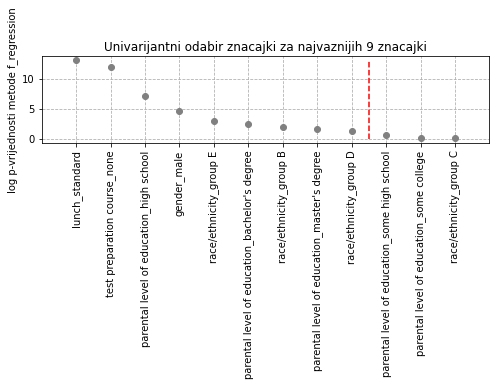

In [13]:
odaberi(feature_selection.f_regression,k_best,X_train_N, y_train_N,yname="f_regression")

### 2.Odabir encodinga za feature selection : Label


In [14]:
X_features_encoded = encode_data(df,enc_type="LABEL")
Y = df["AVERAGE"]

k_best = int(len(X_features_encoded.columns)*0.8) 

In [15]:
X_train_N, X_test_N, y_train_N, y_test_N = train_test_split(
    X_features_encoded, 
    Y, 
    test_size=0.2, 
    shuffle = True, 
    random_state=1
)

y_train_N=y_train_N.astype('int')

### Rezultat s metodom: f_regression

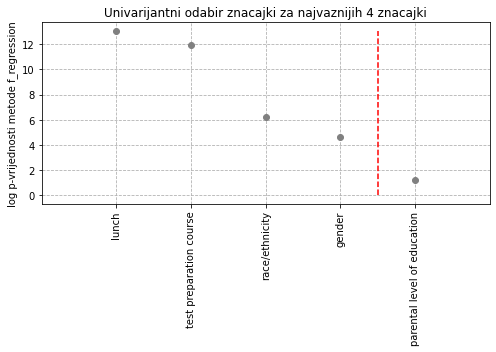

In [16]:
odaberi(feature_selection.f_regression,k_best,X_train_N, y_train_N,yname="f_regression")

Zaključak: 
Maknut ćemo značajku $\text{parental level of education}$, i vidjeti točnost modela bez nje.

# Modeli

Na raspolaganju imamo puno različitih algoritama strojnog učenja koje možemo primjeniti na ovaj problem. Ideja je da prvo krenemo od jednostavnijih, pa nadograđujemo prema onim kompleksnijim modelima. 
Za početak ćemo iskoristiti sljedeće algoritme:
        
        - Algoritmi regresije
        - Support vector machines (SVM)
        - Slučajne šume

## Priprema podataka

### Funkcije za ispis grešaka

In [17]:
def evaluateRegressor(true,predicted,message = "Test set evaluation:"):
    MSE = mean_squared_error(true,predicted,squared = True)
    MAE = mean_absolute_error(true,predicted)
    RMSE = mean_squared_error(true,predicted,squared = False)
    R_squared = r2_score(true,predicted)
    print(message)
    print("MSE:", MSE)
    print("MAE:", MAE)
    print("RMSE:", RMSE)
    print(f"R-squared: {R_squared} , from <0,1> ")
    return [MSE,MAE,RMSE,R_squared]

### Train Test Split
Pošto nemamo unaprijed zadane trening i test podatke, uobičajeno je podijeliti cijelu našu bazu u dio za trening i dio za test. Najčešće se koristi sklearn funkcija train_test_split koja prima postotak podataka koji želimo da bude testni. U našem slučaju stavit ćemo 20% (800 trening, 200 test podataka).

    X_features_encoded:    dataset kodiran pomoću odabranog encodinga
    X_features_encoded_FS: isti dataset bez stupca kojeg smo maknuli feature selectionom
    Y:                     skup oznaka (numerički)
    Y_class:               skup oznaka (kategorički, ocjene od 1 do 5) 
    

In [18]:
#KOJI CEMO ENCODING KORISTITI
encoding= "LABEL"

feature_selection_column="lunch"

numeric_cols=["math score","reading score","writing score","AVERAGE"]

In [19]:
Y = df["AVERAGE"]
Y_class= pd.cut(Y,
       5, labels=[1,2,3,4,5])

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(numeric_cols,axis = 'columns'), 
    Y, 
    test_size=0.2, 
    shuffle = True, 
    #random_state=1
)
#y_train_N=y_train_N.astype('int')

X_train = encode_data(X_train,removeY=False,enc_type=encoding)
X_test = encode_data(X_test,removeY=False,enc_type=encoding)

X_train_FS = X_train.drop([feature_selection_column],axis = 'columns')
X_test_FS = X_test.drop([feature_selection_column],axis = 'columns')


In [20]:
df_temp = df.copy()
df_temp['Total score'] = ((df['math score']+df['writing score']+df['reading score'])/3).round(2)
df_temp=df_temp.drop(["AVERAGE"],axis = 'columns')

In [21]:
df2 = one_hot_encoding(df_temp)
train, test = train_test_split(df2, test_size=0.2)
features = train.loc[:, 'gender' : 'test preparation course']
targets = train.loc[:, 'math score' : 'Total score']

Ako ce nam trebat skalirani podaci ,tu su

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Evaluacije spremamo u tablicu

In [23]:
data=[]
data=pd.DataFrame(data, columns=["MSE", "MAE","RMSE", "R^2"])
data.index.astype(str, copy = False)

data

,MSE,MAE,RMSE,R^2


## Modeli linearne regresije

Osnovni algoritam regresije (a i cijele teorije strojnog učenja) je linearna regresija. Osim nje, postoje i neke modifikacije. Svaka ima svoje prednosti i mane, zbog kojih se sve koriste u određenim situacijama. Mi ćemo iskoristiti Lasso i Ridge, te usporediti rezultate svih.

### Linearna Regresija

In [25]:
LinearReg = LinearRegression(normalize = True)
LinearReg = LinearReg.fit(X_train,y_train)

LinearReg_FS = LinearRegression(normalize = True)
LinearReg_FS = LinearReg_FS.fit(X_train_FS,y_train)

predicted_y_test = LinearReg.predict(X_test)
predicted_y_test_FS=LinearReg_FS.predict(X_test_FS)

In [26]:
data.loc['linearna'] = evaluateRegressor(y_test, predicted_y_test)
data.loc['linearna_fs'] = evaluateRegressor(y_test, predicted_y_test_FS)

data

Test set evaluation:
MSE: 152.21385033180755
MAE: 9.61776960327828
RMSE: 12.337497733811649
R-squared: 0.1341961934730046 , from <0,1> 
Test set evaluation:
MSE: 165.14119883511196
MAE: 9.939938247452815
RMSE: 12.850727560535706
R-squared: 0.060664464802692164 , from <0,1> 


,MSE,MAE,RMSE,R^2
linearna,152.213850,9.617770,12.337498,0.134196
linearna_fs,165.141199,9.939938,12.850728,0.060664


### MultitaskLasso Regresija (3 izlaza)

In [27]:
X_lasso =df.drop(["math score","reading score","writing score","AVERAGE"],axis = 'columns') 
Y_3_lasso =df[["math score","reading score","writing score"]]

X_lasso = encode_data(X_lasso,enc_type="LABEL",removeY=False)

In [28]:
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(
    X_lasso, 
    Y_3_lasso, 
    test_size=0.2, 
    shuffle = True, 
    #random_state=1
)

In [29]:
# import linear model library
from sklearn import linear_model
  
# create MultiTaskLasso model
MTL = linear_model.MultiTaskLasso(alpha = 0.5)

# fit the model to a data
#MTL.fit([[1, 0], [1, 3], [2, 2]], [[0, 2], [1, 4], [2, 4]])
MTL.fit(X_train_lasso,y_train_lasso)

pred=MTL.predict(X_test_lasso)
# perform prediction and print the result
#print("Prediciton result: \n", MTL.predict(X_test_lasso), "\n")
  
# print the coefficients
#print("Coefficients: \n", MTL.coef_, "\n")
  
# print the intercepts
#print("Intercepts: \n", MTL.intercept_, "\n")
  
# print the number of iterations performed
#print("Number of Iterations: ", MTL.n_iter_, "\n")

In [30]:
#residual(y_test_lasso, pred)

print("\nScores:")

data.loc['Multi-Lasso'] = evaluateRegressor(y_test_lasso, pred)


Scores:
Test set evaluation:
MSE: 164.30689077138635
MAE: 10.525674038635469
RMSE: 12.815223524328914
R-squared: 0.23664930771017936 , from <0,1> 


## Ridge regresija

Objasnjena varijanca = 0.21
R2 = 0.21
MSE = 149.27


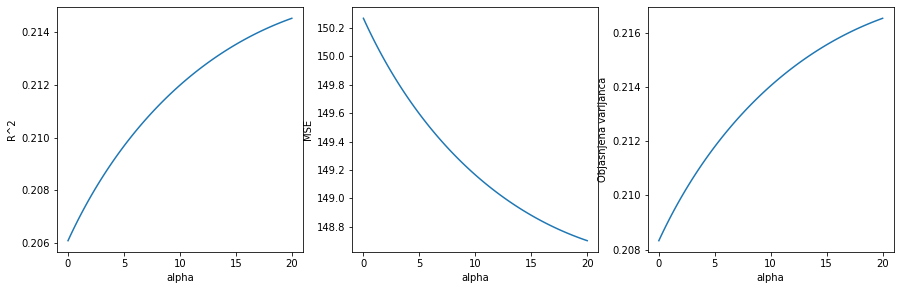

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))
alpha_array = np.linspace(0.01, 20.0, 100)
R2 = []
MSE = []
explained_variance = []

correct_scores = test.loc[:, 'math score' : 'Total score']


for alpha in alpha_array:
    model_ridge = Pipeline( [ ('ridge', Ridge(alpha=alpha)) ] )
    model_ridge = model_ridge.fit(features, targets)
    #R2_ridge = model_ridge.score(test.loc[:, 'gender' : 'test preparation course'], correct_scores)
    regr_pred = model_ridge.predict(test.loc[:, 'gender' : 'test preparation course'])
    
    
    explained_variance.append(explained_variance_score(correct_scores, regr_pred))
    R2.append(r2_score(correct_scores, regr_pred))
    MSE.append(mean_squared_error(correct_scores, regr_pred))

def avg(arr):
    return sum(arr) / len(arr)

print('Objasnjena varijanca = '+'{0:.2f}'.format(avg(explained_variance))+'\nR2 = '+'{0:.2f}'.format(avg(R2))+'\nMSE = '+'{0:.2f}'.format(avg(MSE)))


ax[0].plot(alpha_array, R2)
ax[0].set(xlabel='alpha', ylabel='R^2')
ax[1].plot(alpha_array, MSE)
ax[1].set(xlabel='alpha', ylabel='MSE')
ax[2].plot(alpha_array, explained_variance)
ax[2].set(xlabel='alpha', ylabel='Objasnjena varijanca')

plt.show()

## LightGBM

In [32]:
LGBMReg = lgb.LGBMRegressor(random_state=0).fit(X_train,y_train)
LGBMReg_FS = lgb.LGBMRegressor(random_state=0).fit(X_train_FS,y_train)

#predicted_y_train = LGBMReg.predict(X_train)
#evaluateRegressor(y_train,predicted_y_train,"    Training Set")

predicted_y_test = LGBMReg.predict(X_test)
data.loc['LightGBM'] = evaluateRegressor(y_test,predicted_y_test)

predicted_y_test_FS = LGBMReg_FS.predict(X_test_FS)
data.loc['LightGBM_FS'] = evaluateRegressor(y_test,predicted_y_test_FS)


Test set evaluation:
MSE: 171.49397223755253
MAE: 10.42809882159599
RMSE: 13.095570710646884
R-squared: 0.024529412822556385 , from <0,1> 
Test set evaluation:
MSE: 178.3767767922669
MAE: 10.91834127796365
RMSE: 13.355776907101545
R-squared: -0.014620496138177508 , from <0,1> 


### Koji atributi najviše pridonose modelu LightGBM

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

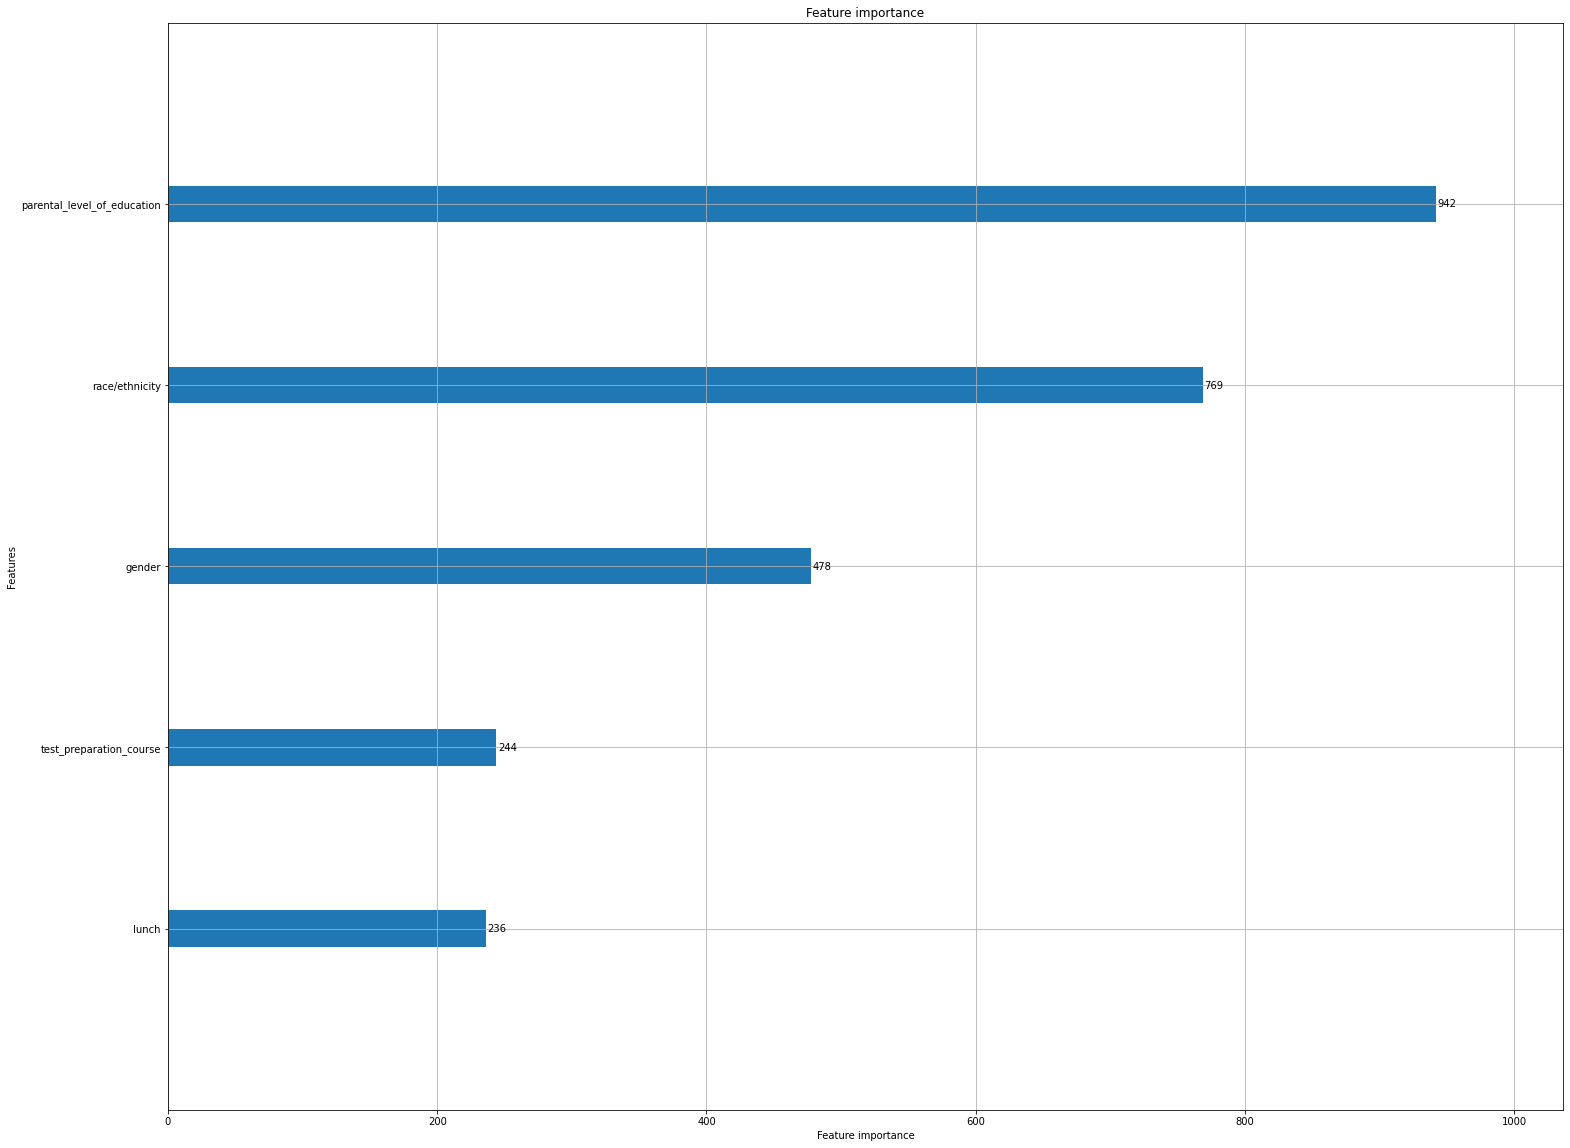

In [33]:
lgb.plot_importance(LGBMReg,figsize=(25,20))

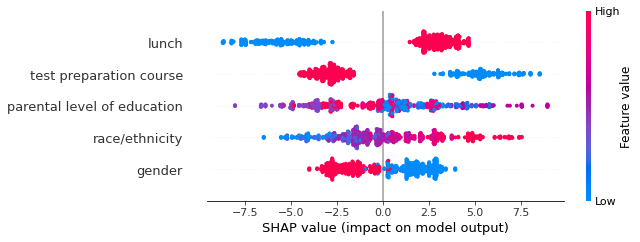

In [34]:
#LGBMReg.params['objective'] = 'regression'
shap_values = shap.TreeExplainer(LGBMReg).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

## k Najbližih susjeda (kNN)

In [35]:
from sklearn import neighbors

mse = []
mse_train=[]
maxx=[]
maxx_train=[]
r2=[]
r2_train=[]

for i in range(150):
    i = i+1
    model = neighbors.KNeighborsRegressor(n_neighbors = i)
    model.fit(X_train, y_train) 
    pred=model.predict(X_test) 
    pred_train=model.predict(X_train) 
    
    mse.append(mean_squared_error(y_test,pred)) 
    mse_train.append(mean_squared_error(y_train,pred_train)) 
    
    maxx.append(max_error(y_test,pred)) 
    maxx_train.append(max_error(y_train,pred_train)) 
    
    r2.append(r2_score(y_test,pred)) 
    r2_train.append(r2_score(y_train,pred_train)) 
    
    


In [36]:
mse2=pd.DataFrame({"k": range(1,151),"MSE": mse})
min_index_mse = mse2.iloc[:,1].idxmin()

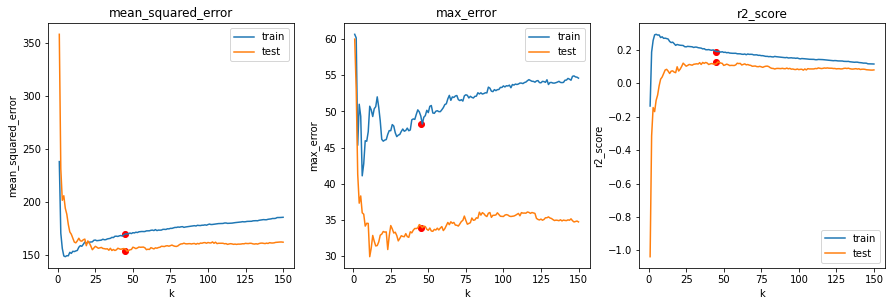

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))

train=[mse_train,maxx_train,r2_train]
test=[mse,maxx,r2]
labels=["mean_squared_error","max_error","r2_score"]
titles=["mean_squared_error","max_error","r2_score"]


for i in range(3):
    tr= train[i]
    ts= test[i]
    ylab=labels[i]
    title=titles[i]
    
    ax[i].plot(min_index_mse,tr[min_index_mse],'ro')
    ax[i].plot(min_index_mse,ts[min_index_mse],'ro')
    
    ax[i].plot(np.arange(1,150+1),tr,label='train')
    ax[i].plot(np.arange(1,150+1),ts,label='test')
    
    ax[i].set(xlabel='k')
    ax[i].set(ylabel=ylab)
    ax[i].title.set_text(title)
    ax[i].legend()




plt.show()

### Uzimamo onaj model s najmanjim MSE

In [38]:
model = neighbors.KNeighborsRegressor(n_neighbors =min_index_mse)
model.fit(X_train, y_train) 

model_FS = neighbors.KNeighborsRegressor(n_neighbors = min_index_mse)
model_FS.fit(X_train_FS, y_train) 

pred=model.predict(X_test)
pred_FS=model_FS.predict(X_test_FS)

In [39]:
data.loc['kNN'] = evaluateRegressor(y_test, pred)
data.loc['kNN_FS'] = evaluateRegressor(y_test, pred_FS)

Test set evaluation:
MSE: 155.49599807956108
MAE: 9.920185185185185
RMSE: 12.469803449916967
R-squared: 0.11552709071136735 , from <0,1> 
Test set evaluation:
MSE: 167.9258159122085
MAE: 10.324925925925927
RMSE: 12.95861936751784
R-squared: 0.04482535384258768 , from <0,1> 


## CATBoost

### Pretraživanje hiperparametra: $iterations$

In [40]:
from catboost import CatBoostRegressor

train_data = X_train
eval_data = X_test
train_labels = y_train


k=50

treeScoresTest1=np.zeros(k)
treeScoresTrain1=np.zeros(k)
treeScoresTest2=np.zeros(k)
treeScoresTrain2=np.zeros(k)
treeScoresTest3=np.zeros(k)
treeScoresTrain3=np.zeros(k)

for i in np.arange(1,k+1):
        # Initialize CatBoostRegressor
    model = CatBoostRegressor(iterations=i,
                              learning_rate=1,
                              depth=2)
    # Fit model
    model.fit(train_data, train_labels)
    
    
    treeScoresTrain1[i-1]=r2_score(y_train, model.predict(X_train))
    treeScoresTest1[i-1] =r2_score(y_test, model.predict(X_test))
    treeScoresTrain2[i-1]= max_error(y_train, model.predict(X_train))
    treeScoresTest2[i-1] = max_error(y_test, model.predict(X_test))
    treeScoresTrain3[i-1]= mean_squared_error (y_train, model.predict(X_train))
    treeScoresTest3[i-1] = mean_squared_error (y_test, model.predict(X_test))


0:	learn: 13.2175032	total: 138ms	remaining: 0us
0:	learn: 13.2175032	total: 695us	remaining: 695us
1:	learn: 13.0801232	total: 1.39ms	remaining: 0us
0:	learn: 13.2175032	total: 590us	remaining: 1.18ms
1:	learn: 13.0801232	total: 1.24ms	remaining: 618us
2:	learn: 12.7501408	total: 1.88ms	remaining: 0us
0:	learn: 13.2175032	total: 583us	remaining: 1.75ms
1:	learn: 13.0801232	total: 1.22ms	remaining: 1.22ms
2:	learn: 12.7501408	total: 1.84ms	remaining: 615us
3:	learn: 12.7058908	total: 2.47ms	remaining: 0us
0:	learn: 13.2175032	total: 603us	remaining: 2.41ms
1:	learn: 13.0801232	total: 1.28ms	remaining: 1.92ms
2:	learn: 12.7501408	total: 1.89ms	remaining: 1.26ms
3:	learn: 12.7058908	total: 2.51ms	remaining: 627us
4:	learn: 12.6253224	total: 3.12ms	remaining: 0us
0:	learn: 13.2175032	total: 560us	remaining: 2.8ms
1:	learn: 13.0801232	total: 1.26ms	remaining: 2.53ms
2:	learn: 12.7501408	total: 1.75ms	remaining: 1.75ms
3:	learn: 12.7058908	total: 2.22ms	remaining: 1.11ms
4:	learn: 12.625322

0:	learn: 13.2175032	total: 2.1ms	remaining: 42ms
1:	learn: 13.0801232	total: 2.73ms	remaining: 26ms
2:	learn: 12.7501408	total: 3.26ms	remaining: 19.6ms
3:	learn: 12.7058908	total: 3.77ms	remaining: 16ms
4:	learn: 12.6253224	total: 4.27ms	remaining: 13.7ms
5:	learn: 12.6056887	total: 4.77ms	remaining: 11.9ms
6:	learn: 12.5677644	total: 5.26ms	remaining: 10.5ms
7:	learn: 12.5428867	total: 5.73ms	remaining: 9.32ms
8:	learn: 12.5204796	total: 6.21ms	remaining: 8.28ms
9:	learn: 12.4739942	total: 6.68ms	remaining: 7.35ms
10:	learn: 12.4597135	total: 7.34ms	remaining: 6.67ms
11:	learn: 12.4344596	total: 7.82ms	remaining: 5.87ms
12:	learn: 12.4216511	total: 8.3ms	remaining: 5.11ms
13:	learn: 12.4137974	total: 8.86ms	remaining: 4.43ms
14:	learn: 12.4065765	total: 9.34ms	remaining: 3.73ms
15:	learn: 12.4031638	total: 10.3ms	remaining: 3.23ms
16:	learn: 12.4003141	total: 11ms	remaining: 2.58ms
17:	learn: 12.3994514	total: 11.6ms	remaining: 1.93ms
18:	learn: 12.3834019	total: 12.1ms	remaining: 1

1:	learn: 13.0801232	total: 1.45ms	remaining: 20.2ms
2:	learn: 12.7501408	total: 2.03ms	remaining: 18.3ms
3:	learn: 12.7058908	total: 2.7ms	remaining: 17.5ms
4:	learn: 12.6253224	total: 3.25ms	remaining: 16.2ms
5:	learn: 12.6056887	total: 3.77ms	remaining: 15.1ms
6:	learn: 12.5677644	total: 4.34ms	remaining: 14.3ms
7:	learn: 12.5428867	total: 5.09ms	remaining: 14ms
8:	learn: 12.5204796	total: 5.65ms	remaining: 13.2ms
9:	learn: 12.4739942	total: 6.23ms	remaining: 12.5ms
10:	learn: 12.4597135	total: 7.61ms	remaining: 13.1ms
11:	learn: 12.4344596	total: 8.04ms	remaining: 12.1ms
12:	learn: 12.4216511	total: 8.49ms	remaining: 11.1ms
13:	learn: 12.4137974	total: 9.09ms	remaining: 10.4ms
14:	learn: 12.4065765	total: 10.4ms	remaining: 10.4ms
15:	learn: 12.4031638	total: 10.9ms	remaining: 9.53ms
16:	learn: 12.4003141	total: 11.4ms	remaining: 8.69ms
17:	learn: 12.3994514	total: 11.9ms	remaining: 7.92ms
18:	learn: 12.3834019	total: 12.4ms	remaining: 7.16ms
19:	learn: 12.3724673	total: 12.8ms	rema

0:	learn: 13.2175032	total: 550us	remaining: 18.7ms
1:	learn: 13.0801232	total: 1.16ms	remaining: 19.2ms
2:	learn: 12.7501408	total: 1.77ms	remaining: 18.9ms
3:	learn: 12.7058908	total: 2.29ms	remaining: 17.8ms
4:	learn: 12.6253224	total: 2.8ms	remaining: 16.8ms
5:	learn: 12.6056887	total: 3.3ms	remaining: 15.9ms
6:	learn: 12.5677644	total: 3.77ms	remaining: 15.1ms
7:	learn: 12.5428867	total: 4.25ms	remaining: 14.3ms
8:	learn: 12.5204796	total: 4.73ms	remaining: 13.7ms
9:	learn: 12.4739942	total: 5.19ms	remaining: 13ms
10:	learn: 12.4597135	total: 5.65ms	remaining: 12.3ms
11:	learn: 12.4344596	total: 6.13ms	remaining: 11.8ms
12:	learn: 12.4216511	total: 6.61ms	remaining: 11.2ms
13:	learn: 12.4137974	total: 7.11ms	remaining: 10.7ms
14:	learn: 12.4065765	total: 7.61ms	remaining: 10.2ms
15:	learn: 12.4031638	total: 8.3ms	remaining: 9.85ms
16:	learn: 12.4003141	total: 8.9ms	remaining: 9.43ms
17:	learn: 12.3994514	total: 9.42ms	remaining: 8.89ms
18:	learn: 12.3834019	total: 10ms	remaining: 

0:	learn: 13.2175032	total: 552us	remaining: 21.5ms
1:	learn: 13.0801232	total: 1.43ms	remaining: 27.3ms
2:	learn: 12.7501408	total: 1.96ms	remaining: 24.1ms
3:	learn: 12.7058908	total: 2.48ms	remaining: 22.3ms
4:	learn: 12.6253224	total: 3ms	remaining: 21ms
5:	learn: 12.6056887	total: 3.44ms	remaining: 19.5ms
6:	learn: 12.5677644	total: 4.01ms	remaining: 18.9ms
7:	learn: 12.5428867	total: 4.5ms	remaining: 18ms
8:	learn: 12.5204796	total: 4.98ms	remaining: 17.2ms
9:	learn: 12.4739942	total: 5.44ms	remaining: 16.3ms
10:	learn: 12.4597135	total: 5.93ms	remaining: 15.6ms
11:	learn: 12.4344596	total: 6.39ms	remaining: 14.9ms
12:	learn: 12.4216511	total: 6.85ms	remaining: 14.2ms
13:	learn: 12.4137974	total: 7.31ms	remaining: 13.6ms
14:	learn: 12.4065765	total: 7.78ms	remaining: 13ms
15:	learn: 12.4031638	total: 8.24ms	remaining: 12.4ms
16:	learn: 12.4003141	total: 8.71ms	remaining: 11.8ms
17:	learn: 12.3994514	total: 9.19ms	remaining: 11.2ms
18:	learn: 12.3834019	total: 9.67ms	remaining: 10

0:	learn: 13.2175032	total: 556us	remaining: 24.5ms
1:	learn: 13.0801232	total: 1.52ms	remaining: 32.7ms
2:	learn: 12.7501408	total: 2.15ms	remaining: 30ms
3:	learn: 12.7058908	total: 4.19ms	remaining: 42.9ms
4:	learn: 12.6253224	total: 4.99ms	remaining: 39.9ms
5:	learn: 12.6056887	total: 5.54ms	remaining: 36ms
6:	learn: 12.5677644	total: 6.01ms	remaining: 32.6ms
7:	learn: 12.5428867	total: 6.49ms	remaining: 30ms
8:	learn: 12.5204796	total: 6.98ms	remaining: 27.9ms
9:	learn: 12.4739942	total: 7.45ms	remaining: 26.1ms
10:	learn: 12.4597135	total: 7.94ms	remaining: 24.5ms
11:	learn: 12.4344596	total: 8.48ms	remaining: 23.3ms
12:	learn: 12.4216511	total: 9ms	remaining: 22.2ms
13:	learn: 12.4137974	total: 9.56ms	remaining: 21.2ms
14:	learn: 12.4065765	total: 10ms	remaining: 20ms
15:	learn: 12.4031638	total: 10.4ms	remaining: 18.9ms
16:	learn: 12.4003141	total: 12.2ms	remaining: 20.1ms
17:	learn: 12.3994514	total: 13.5ms	remaining: 20.2ms
18:	learn: 12.3834019	total: 14.1ms	remaining: 19.3m

1:	learn: 13.0801232	total: 1.36ms	remaining: 31.9ms
2:	learn: 12.7501408	total: 1.86ms	remaining: 28.6ms
3:	learn: 12.7058908	total: 2.35ms	remaining: 26.5ms
4:	learn: 12.6253224	total: 2.89ms	remaining: 25.4ms
5:	learn: 12.6056887	total: 3.46ms	remaining: 24.8ms
6:	learn: 12.5677644	total: 3.94ms	remaining: 23.6ms
7:	learn: 12.5428867	total: 4.4ms	remaining: 22.6ms
8:	learn: 12.5204796	total: 4.87ms	remaining: 21.7ms
9:	learn: 12.4739942	total: 5.33ms	remaining: 20.8ms
10:	learn: 12.4597135	total: 5.78ms	remaining: 20ms
11:	learn: 12.4344596	total: 6.24ms	remaining: 19.2ms
12:	learn: 12.4216511	total: 6.71ms	remaining: 18.6ms
13:	learn: 12.4137974	total: 7.18ms	remaining: 18ms
14:	learn: 12.4065765	total: 7.63ms	remaining: 17.3ms
15:	learn: 12.4031638	total: 8.08ms	remaining: 16.7ms
16:	learn: 12.4003141	total: 8.55ms	remaining: 16.1ms
17:	learn: 12.3994514	total: 9.03ms	remaining: 15.5ms
18:	learn: 12.3834019	total: 9.53ms	remaining: 15.1ms
19:	learn: 12.3724673	total: 10ms	remainin

Max test: 0.134
Max train:0.281
Max test index:3


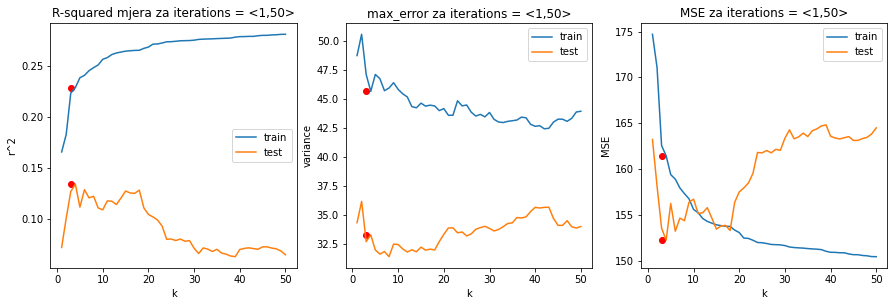

In [41]:
maximumTE = np.max(treeScoresTest1)
minimumTR = np.max(treeScoresTrain1)

print("Max test: " + str(round(maximumTE,3)) )
print("Max train:" + str(round(minimumTR,3)) )

index_of_maximum = np.where(treeScoresTest1 == maximumTE)[0][0]
print("Max test index:" + str(index_of_maximum) )


fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))

train=[treeScoresTrain1,treeScoresTrain2,treeScoresTrain3]
test=[treeScoresTest1,treeScoresTest2,treeScoresTest3]
labels=["r^2","variance","MSE"]
titles=[f"R-squared mjera za iterations = <1,{k}>",f"max_error za iterations = <1,{k}>",f"MSE za iterations = <1,{k}>"]

for i in range(3):
    tr= train[i]
    ts= test[i]
    ylab=labels[i]
    title=titles[i]
    
    ax[i].plot(index_of_maximum,tr[index_of_maximum],'ro')
    ax[i].plot(index_of_maximum,ts[index_of_maximum],'ro')
    
    ax[i].plot(np.arange(1,k+1),tr,label='train')
    ax[i].plot(np.arange(1,k+1),ts,label='test')
    
    ax[i].set(xlabel='k')
    ax[i].set(ylabel=ylab)
    ax[i].title.set_text(title)
    ax[i].legend()




plt.show()

### Najbolji hiperparametar $iterations$ nađen

In [42]:

model = CatBoostRegressor(iterations=index_of_maximum,
                          learning_rate=1,
                          depth=2)

model.fit(train_data, train_labels)

pred = model.predict(eval_data)

0:	learn: 13.2175032	total: 829us	remaining: 1.66ms
1:	learn: 13.0801232	total: 1.58ms	remaining: 792us
2:	learn: 12.7501408	total: 2.15ms	remaining: 0us


In [43]:
print("\nScores:")
data.loc['CATBoost'] = evaluateRegressor(y_test, pred)


Scores:
Test set evaluation:
MSE: 153.55595663485818
MAE: 9.709333646723417
RMSE: 12.391769713598546
R-squared: 0.12656219207686303 , from <0,1> 


## ANN

In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


model = Sequential()
model.add(Dense(100, input_dim=X_train.columns.value_counts().sum(), activation="softmax"))
model.add(Dense(100, activation="relu"))
model.add(Dense(1, kernel_initializer="normal"))
model.compile(loss="mean_squared_error", optimizer = "adam", metrics = ["mse"])

model.fit(X_train, y_train, epochs=10)

Epoch 1/10
25/25 [==============================] - 1s 2ms/step - loss: 4747.7075 - mse: 4747.7075
Epoch 2/10
25/25 [==============================] - 0s 2ms/step - loss: 4711.6904 - mse: 4711.6904
Epoch 3/10
25/25 [==============================] - 0s 2ms/step - loss: 4642.8511 - mse: 4642.8511
Epoch 4/10
25/25 [==============================] - 0s 2ms/step - loss: 4531.3750 - mse: 4531.3750
Epoch 5/10
25/25 [==============================] - 0s 2ms/step - loss: 4373.8848 - mse: 4373.8848
Epoch 6/10
25/25 [==============================] - 0s 2ms/step - loss: 4172.7036 - mse: 4172.7036
Epoch 7/10
25/25 [==============================] - 0s 2ms/step - loss: 3925.0020 - mse: 3925.0020
Epoch 8/10
25/25 [==============================] - 0s 2ms/step - loss: 3632.3418 - mse: 3632.3418
Epoch 9/10
25/25 [==============================] - 0s 2ms/step - loss: 3303.9580 - mse: 3303.9580
Epoch 10/10
25/25 [==============================] - 0s 2ms/step - loss: 2951.7122 - mse: 2951.7122


In [45]:
from tensorflow.keras.models import Model, load_model
#model.save('cnn_model.h5')
#model = load_model('cnn_model.h5')

predicted_y_test = model.predict(X_test)
predicted_y_test = pd.Series([i[0] for i in predicted_y_test])

In [46]:
data.loc['ANN'] = evaluateRegressor(y_test, predicted_y_test)

Test set evaluation:
MSE: 2897.4176359220455
MAE: 52.16244916915893
RMSE: 53.827666082805834
R-squared: -15.480729006009142 , from <0,1> 


## Slučajne šume

### Pretraživanje hiperparametra: $n\_estimators$

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score,max_error

In [48]:
k=50

treeScoresTest1=np.zeros(k)
treeScoresTrain1=np.zeros(k)
treeScoresTest2=np.zeros(k)
treeScoresTrain2=np.zeros(k)
treeScoresTest3=np.zeros(k)
treeScoresTrain3=np.zeros(k)



#X_train, X_test, y_train, y_test 


for k in np.arange(1,k+1):
    rf = RandomForestRegressor(n_estimators=k)
    rf.fit(X_train,y_train)
    treeScoresTrain1[k-1]=r2_score(y_train, rf.predict(X_train))
    treeScoresTest1[k-1] =r2_score(y_test, rf.predict(X_test))
    treeScoresTrain2[k-1]= max_error(y_train, rf.predict(X_train))
    treeScoresTest2[k-1] = max_error(y_test, rf.predict(X_test))
    treeScoresTrain3[k-1]= mean_squared_error (y_train, rf.predict(X_train))
    treeScoresTest3[k-1] = mean_squared_error (y_test, rf.predict(X_test))

Max test: -0.04
Max train:0.41
Max test index:17


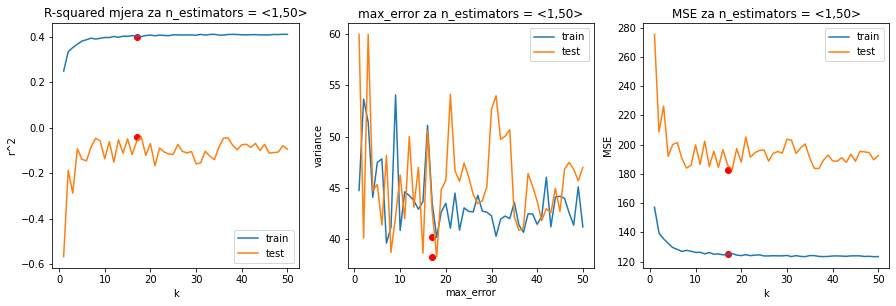

In [49]:

maximumTE = np.max(treeScoresTest1)
minimumTR = np.max(treeScoresTrain1)

print("Max test: " + str(round(maximumTE,3)) )
print("Max train:" + str(round(minimumTR,3)) )

index_of_maximum = np.where(treeScoresTest1 == maximumTE)[0][0]
print("Max test index:" + str(index_of_maximum) )


fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))


ax[0].plot(index_of_maximum,treeScoresTrain1[index_of_maximum],'ro')
ax[0].plot(index_of_maximum,treeScoresTest1[index_of_maximum],'ro')
ax[0].plot(np.arange(1,k+1),treeScoresTrain1,label='train')
ax[0].plot(np.arange(1,k+1),treeScoresTest1,label='test')
ax[0].set(xlabel='k', ylabel='r^2')
ax[0].title.set_text(f"R-squared mjera za n_estimators = <1,{k}>")
ax[0].legend()

ax[1].plot(index_of_maximum,treeScoresTrain2[index_of_maximum],'ro')
ax[1].plot(index_of_maximum,treeScoresTest2[index_of_maximum],'ro')

ax[1].plot(np.arange(1,k+1),treeScoresTrain2,label='train')
ax[1].plot(np.arange(1,k+1),treeScoresTest2,label='test')
ax[1].set(xlabel='max_error', ylabel='variance')
ax[1].title.set_text(f"max_error za n_estimators = <1,{k}>")
ax[1].legend()

ax[2].plot(index_of_maximum,treeScoresTrain3[index_of_maximum],'ro')
ax[2].plot(index_of_maximum,treeScoresTest3[index_of_maximum],'ro')

ax[2].plot(np.arange(1,k+1),treeScoresTrain3,label='train')
ax[2].plot(np.arange(1,k+1),treeScoresTest3,label='test')
ax[2].set(xlabel='k', ylabel='MSE')
ax[2].title.set_text(f"MSE za n_estimators = <1,{k}>")
ax[2].legend()


plt.show()



### Našli smo $\text{n_estimators}$ koji daje najmanju grešku nad $test$ skupom:

In [50]:
rf = RandomForestRegressor(n_estimators=index_of_maximum)
rf.fit(X_train,y_train)
# Predictions
predictions = rf.predict(X_test)

In [51]:

data.loc['Random forest'] =evaluateRegressor(y_test, predictions)

Test set evaluation:
MSE: 188.85572485943484
MAE: 10.915885409312017
RMSE: 13.742478846970617
R-squared: -0.07422553934006304 , from <0,1> 


### Koji atributi doprinose najviše modelu slučajnih šuma

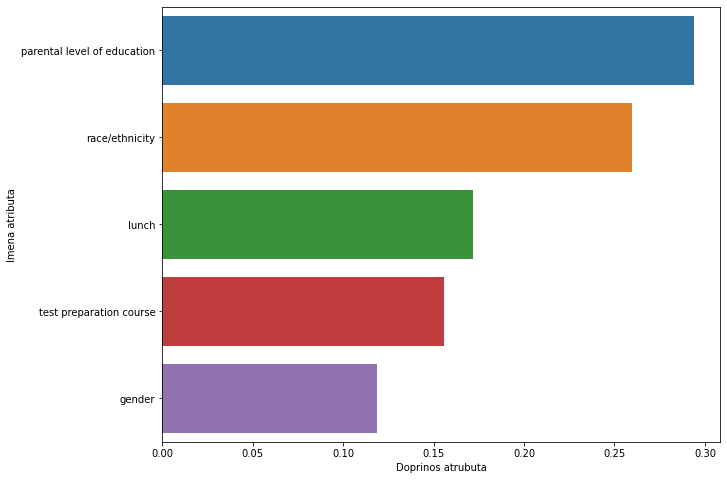

In [52]:
feature_importance = np.array(rf.feature_importances_)
feature_names = np.array(X_train.columns)
data2={'feature_names':feature_names,'feature_importance':feature_importance}
df_plt = pd.DataFrame(data2)
df_plt.sort_values(by=['feature_importance'], ascending=False,inplace=True)
plt.figure(figsize=(10,8))
sns.barplot(x=df_plt['feature_importance'], y=df_plt['feature_names'])
plt.xlabel('Doprinos atrubuta')
plt.ylabel('Imena atributa')
plt.show()

## SVM

In [53]:
from sklearn.svm import SVR
def SV_reg(kernel,X_train, y_train):
    model=SVR(kernel)
    model.fit(X_train, y_train)
    return model


SVM_model= SV_reg("linear",X_train, y_train)
pred_linear = SVM_model.predict(X_test)
linear_rmse = np.sqrt(mean_squared_error(y_test,pred_linear))

SVM_model= SV_reg("poly",X_train, y_train)
pred_poly = SVM_model.predict(X_test)
poly_rmse = np.sqrt(mean_squared_error(y_test,pred_poly))

SVM_model= SV_reg("sigmoid",X_train, y_train)
pred_sigmoid = SVM_model.predict(X_test)
sigmoid_rmse = np.sqrt(mean_squared_error(y_test,pred_sigmoid))

SVM_model= SV_reg("rbf",X_train, y_train)
pred_rbf = SVM_model.predict(X_test)
rbf_rmse = np.sqrt(mean_squared_error(y_test,pred_rbf))



data2 = {"kernel":pd.Series(["linear","polynomial","sigmoid","rbf"]),
            "Test RMSE":pd.Series([linear_rmse,poly_rmse,sigmoid_rmse,rbf_rmse])}
table_rmse=pd.DataFrame(data2)
table_rmse

,kernel,Test RMSE
0,linear,12.273347
1,polynomial,12.703725
2,sigmoid,22.655129
3,rbf,12.540597


### Umjesto ručnog pretraživanja hiperparametara $C$ i $\text{gamma}\ \gamma$ , koristimo funkciju $GridSearchCV$ za traženje hp. za 3 jezgrene fje. s najmanjom greškom

In [54]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

K = 15
#parameters = [{'kernel': ['linear','polynomial','rbf'], 'gamma': [2e-2, 2e-1, 1,  8],'C': [2e-3,2e-2, 2, 4]}]
#scorer = make_scorer(mean_squared_error, greater_is_better=False)
#svr_gs = GridSearchCV(SVR(epsilon = 0.01), parameters, cv = K, scoring=scorer)

#svr_gs.fit(X_train, y_train)
#print(svr_gs.best_params_)

 Naći čemo npr. {'C': 2, 'gamma': 0.002, 'kernel': 'linear'}

In [55]:
regressor = SVR(C=2,gamma=0.002,kernel='linear')
#regressor = SVR(**svr_gs.best_params_)
regressor.fit(X_train,y_train)
pred=regressor.predict(X_test)

In [56]:
data.loc['SVR_best'] = evaluateRegressor(y_test,pred)

Test set evaluation:
MSE: 150.80764796236772
MAE: 9.592491634728942
RMSE: 12.280376539926117
R-squared: 0.14219477810610004 , from <0,1> 


# DoWhy kauzalna analiza

## Priprema podataka

In [57]:
data_X_labeled= encode_data(df,enc_type="LABEL")
data_y_labeled= pd.cut(Y,
       5, labels=[1,2,3,4,5])

spojeno = pd.concat([data_X_labeled, data_y_labeled], axis=1)

In [58]:
spojeno.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'AVERAGE'],
      dtype='object')

## Analiza

In [59]:
import dowhy
from dowhy import CausalModel

In [60]:
model=CausalModel(
        data = spojeno,
        treatment='lunch',
        outcome='AVERAGE',
        common_causes=['gender','test preparation course', 'parental level of education','race/ethnicity']
        )

In [61]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(AVERAGE|parental level of education,gender,test preparati
d[lunch]                                                                      

                          
on course,race/ethnicity))
                          
Estimand assumption 1, Unconfoundedness: If U→{lunch} and U→AVERAGE then P(AVERAGE|lunch,parental level of education,gender,test preparation course,race/ethnicity,U) = P(AVERAGE|lunch,parental level of education,gender,test preparation course,race/ethnicity)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [62]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression", test_significance=True)
print(estimate)
print("Causal Estimate is " + str(estimate.value))
data_1 = spojeno[spojeno["lunch"]==1]
data_0 = spojeno[spojeno["race/ethnicity"]==0]
print("ATE", np.mean(data_1["AVERAGE"].cat.codes)- np.mean(data_0["AVERAGE"].cat.codes))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(AVERAGE|parental level of education,gender,test preparati
d[lunch]                                                                      

                          
on course,race/ethnicity))
                          
Estimand assumption 1, Unconfoundedness: If U→{lunch} and U→AVERAGE then P(AVERAGE|lunch,parental level of education,gender,test preparation course,race/ethnicity,U) = P(AVERAGE|lunch,parental level of education,gender,test preparation course,race/ethnicity)

## Realized estimand
b: AVERAGE~lunch+parental level of education+gender+test preparation course+race/ethnicity
Target units: ate

## Estimate
Mean value: 0.48169465924595345
p-value: [5.06520702e-22]

Causal Estimate is 0.48169465924595345
ATE 0.4540545248671717


refute steps

    The refute steps tests the strength and validity of the causal effect found by the estimate step. There are a variety of different refutation methods, eg. Subset Validation (using only a subset of the data to estimate the causal effect) or Placebo Treatment (turning the treatment into a placebo and seeing its effect on the outcome (the placebo treatment refutation expects the causal effect to go down)) In this case, we’ll be adding an irrelevant common cause to test the strength of the causal relationship between the treatment and outcome. This is useful because it changes the causal model but not the relationship between y_factual and treatment.

In [63]:
refute_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute_results)

Refute: Add a Random Common Cause
Estimated effect:0.48169465924595345
New effect:0.48167411811108485



Adding a random common cause didn’t have much of an effect on the causal effect (as expected) and so we can be more assured of the strength of the causal relationship.

# Rezultati & zaključak

Usporedimo rezultate koje smo dobili:

In [64]:
data

,MSE,MAE,RMSE,R^2
linearna,152.213850,9.617770,12.337498,0.134196
linearna_fs,165.141199,9.939938,12.850728,0.060664
Multi-Lasso,164.306891,10.525674,12.815224,0.236649
LightGBM,171.493972,10.428099,13.095571,0.024529
LightGBM_FS,178.376777,10.918341,13.355777,-0.014620
kNN,155.495998,9.920185,12.469803,0.115527
kNN_FS,167.925816,10.324926,12.958619,0.044825
CATBoost,153.555957,9.709334,12.391770,0.126562
ANN,2897.417636,52.162449,53.827666,-15.480729
Random forest,188.855725,10.915885,13.742479,-0.074226


    U svim modelima predviđeni rezultati imaju dosta veliku grešku. To je možda zato što je skup malen te su atributi kategoričke varijable, te zato što dane varijable jednostavno nemaju nikakvu uzročno posljedičnu vezu oznakama ,tj. rezultatima ispita. Možda bi nam više pomogle varijable koje se odnose više na samog učenika, koliko je sati učio tjedno ili koliko je redovan na nastavi itd.